# Projet 3 : Concevez une application au service de la santé

### Etape 2 : Analyse Exploratoire 

- Importation des librairies 

In [1]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer 
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial

%matplotlib inline
plt.style.use('ggplot') #Style des tracés

In [2]:
pd.set_option('display.max_columns', None ) 
pd.set_option('display.max_rows', None )

- Lire les Datasets OpenFood 

In [3]:
df=pd.read_csv('fr.openfoodfacts.org.products.clean.csv', sep='\t')
test=pd.read_csv('openfoodfact.test.csv', sep='\t')
food= pd.concat([df, test], ignore_index=True)
df.head()

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_4598/1079254770.py:2: DtypeWarning: Columns (1,4,6,10,16,22,23,24,25,26,30,31,32,34,43,52,66,71,88,149) have mixed types. Specify dtype option on import or set low_memory=False.
  test=pd.read_csv('openfoodfact.test.csv', sep='\t')


Unnamed: 0  nutriscore_score  energy_100g  fat_100g  saturated-fat_100g  \
0           3              -5.0        238.0       0.2                 0.1   
1          11              18.0        936.0       8.2                 2.2   
2          20               9.0        264.0       0.0                 0.0   
3          23               1.0        134.0       0.3                 0.1   
4          32              14.0       1594.0      22.0                15.5   

   carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                 3.9          3.9        0.02           10.0       0.09   
1                29.0         22.0        0.00            5.1       4.60   
2                15.5         15.5        0.70            0.2       0.00   
3                 5.3          3.9        1.10            0.9       0.42   
4                27.3         21.9        4.40            4.6       0.10   

   sodium_100g  
0        0.036  
1        1.840  
2        0.000  
3        0.168  
4        0.040

In [4]:
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.head()

nutriscore_score  energy_100g  fat_100g  saturated-fat_100g  \
0              -5.0        238.0       0.2                 0.1   
1              18.0        936.0       8.2                 2.2   
2               9.0        264.0       0.0                 0.0   
3               1.0        134.0       0.3                 0.1   
4              14.0       1594.0      22.0                15.5   

   carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                 3.9          3.9        0.02           10.0       0.09   
1                29.0         22.0        0.00            5.1       4.60   
2                15.5         15.5        0.70            0.2       0.00   
3                 5.3          3.9        1.10            0.9       0.42   
4                27.3         21.9        4.40            4.6       0.10   

   sodium_100g  
0        0.036  
1        1.840  
2        0.000  
3        0.168  
4        0.040

In [6]:
df.shape

(856219, 10)

#### Informations sur les données pour l'application

In [7]:
object_columns = food.select_dtypes(include = ['object']).columns

In [8]:
print(object_columns)

Index(['energy_100g', 'code', 'url', 'creator', 'created_t',
       'created_datetime', 'last_modified_t', 'last_modified_datetime',
       'last_modified_by', 'product_name', 'abbreviated_product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags',
       'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_en', 'origins', 'origins_tags',
       'origins_en', 'manufacturing_places', 'manufacturing_places_tags',
       'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags',
       'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores',
       'countries', 'countries_tags', 'countries_en', 'ingredients_text',
       'ingredients_tags', 'ingredients_analysis_tags', 'allergens', 'traces',
       'traces_tags', 'traces_en', 'serving_size', 'no_nutrition_data',
       'additives', 'additives_tags', 'additives_en', 'nutriscore_grade',
       'pnns_groups_1', 'pnns_groups_2', 'food_group

In [9]:
tags = food.columns[test.columns.str.contains('_tag')].tolist()

In [10]:
tags

['created_t',
 'last_modified_by',
 'abbreviated_product_name',
 'packaging',
 'packaging_text',
 'brands_tags',
 'categories_en',
 'origins_en',
 'labels_tags',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'stores',
 'allergens',
 'additives_n',
 'additives_en',
 'food_groups',
 'states',
 'states_en']

In [11]:
food[tags].sample(5)

created_t   last_modified_by abbreviated_product_name  \
1062123           1494346163          foodvisor                      NaN   
2788122  2021-03-29 14:59:59      charlesnepote                      NaN   
890753            1489066271  org-database-usda                      NaN   
486415                   NaN                NaN                      NaN   
2835218  2021-11-07 23:30:22            packbot                      NaN   

                  packaging packaging_text          brands_tags  \
1062123           Plastique            NaN                 cora   
2788122                 NaN            NaN               walima   
890753                  NaN            NaN               roland   
486415                  NaN            NaN                  NaN   
2835218  Bouteille en verre            NaN  vodka-paradize-gold   

                                             categories_en      origins_en  \
1062123  Dairies,Fermented foods,Fermented milk product...  European Union   
2788122                                                NaN             NaN   
890753   Plant-based foods and beverages,Plant-based fo...             NaN   
486415                                                 NaN             NaN   
2835218                                                NaN          France   

        labels_tags emb_codes_tags first_packaging_code_geo      stores  \
1062123         NaN            NaN                      NaN  Cora,Match   
2788122         NaN            NaN                      NaN         NaN   
890753          NaN            NaN                      NaN         NaN   
486415          NaN            NaN                      NaN         NaN   
2835218         NaN            NaN                      NaN         NaN   

        allergens  additives_n  \
1062123       NaN          0.0   
2788122       NaN          NaN   
890753        NaN          2.0   
486415        NaN          NaN   
2835218       NaN          NaN   

                                              additives_en food_groups  \
1062123                                                NaN   en:cheese   
2788122                                                NaN         NaN   
890753   E102 - Tartrazine,E160a - Carotene,E160ai - Be...         NaN   
486415                                                 NaN         NaN   
2835218                                                NaN         NaN   

                                                    states  \
1062123  en:to-be-completed, en:nutrition-facts-complet...   
2788122  en:to-be-completed, en:nutrition-facts-complet...   
890753   en:to-be-completed, en:nutrition-facts-complet...   
486415                                                 NaN   
2835218  en:to-be-completed, en:nutrition-facts-complet...   

                                                 states_en  
1062123  To be completed,Nutrition facts completed,Ingr...  
2788122  To be completed,Nutrition facts completed,Ingr...  
890753   To be completed,Nutrition facts completed,Ingr...  
486415                                                 NaN  
2835218  To be completed,Nutrition facts completed,Ingr...

In [12]:
food.select_dtypes(include = ['int32','float64']).columns

Index(['nutriscore_score', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'cities',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=125)

- Additifs

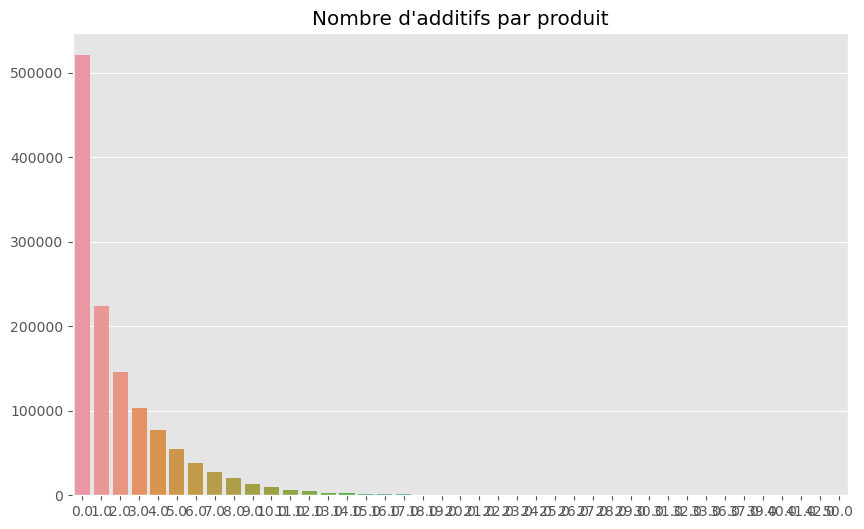

In [13]:
plt.figure(figsize=(10,6))
plt.title('Nombre d\'additifs par produit')
sns.barplot(x = food.additives_n.value_counts().index,
           y = food.additives_n.value_counts().values )
plt.show()

- Nutriscore

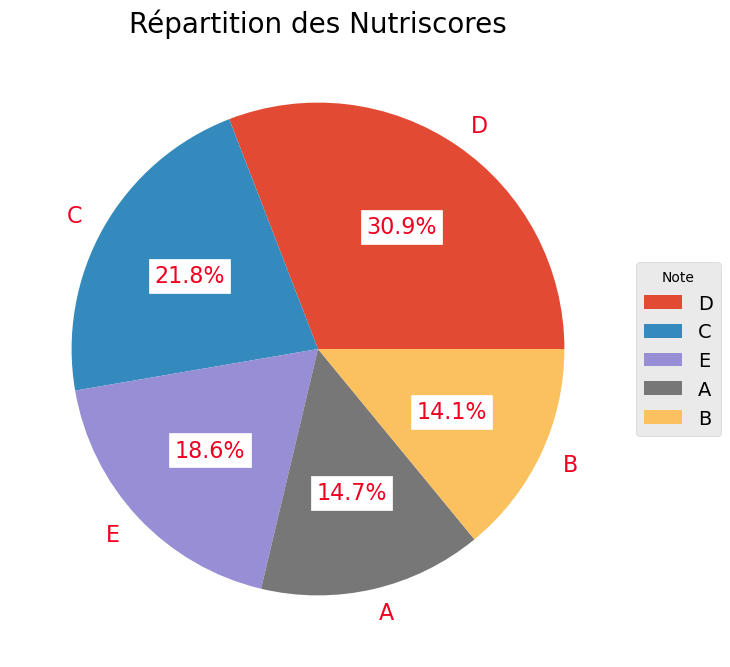

In [14]:
plt.figure(figsize=(8,8))

plt.title('Répartition des Nutriscores', size=20)
wedges, texts, autotexts = plt.pie(food.nutriscore_grade.value_counts().values, 
        labels = food.nutriscore_grade.value_counts().index.str.upper(),
       autopct='%1.1f%%', textprops={'fontsize': 16, 
                                     'color' : '#f00020', 
                                     'backgroundcolor' : '#FFFFFF',}
       )

ax = plt.gca()

ax.legend(wedges, food.nutriscore_grade.value_counts().index.str.upper(),
          title="Note",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(1, 0, 0.5, 1))

### 1 - Analyses univariées


analyse energy_100g

Visualisation des données : Analyse Univariée 

Affichage des allergènes et des produits les plus courants.

Représente la qualité nutritionelle d'un produit. Il s'agit d'un score allant de -15 à 40 basé sur la proportion des différents nutriments dans le produit. Nous avons toutefois modifié l'échelle pour travailler avec un score de 0 à 100.

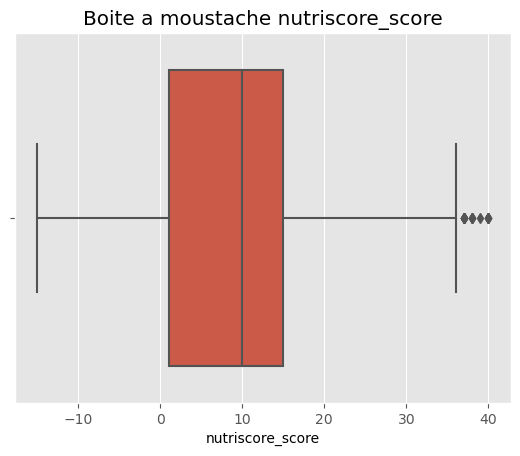

In [15]:
sns.boxplot(x='nutriscore_score', data = df)
plt.title('Boite a moustache nutriscore_score')
plt.savefig('nutriscore_score_fr_boxplot.jpg', bbox_inches='tight')
plt.show()

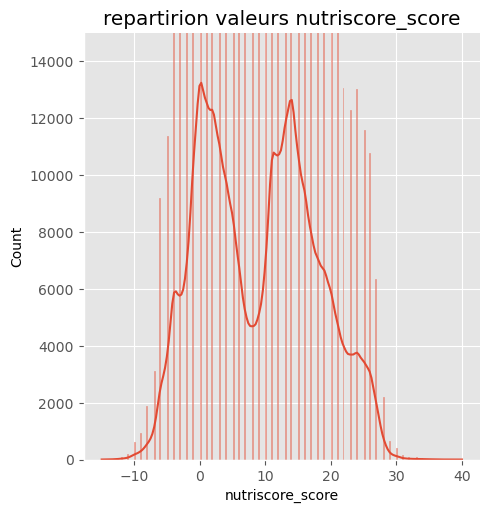

In [16]:
sns.displot(df['nutriscore_score'], kde = True)
plt.ylim(0, 15000)
plt.title('repartirion valeurs nutriscore_score')
plt.savefig('nutriscore_score_fr.jpg', bbox_inches='tight')
plt.show()

In [17]:
df['nutriscore_score'].describe()

count    856219.000000
mean          8.990573
std           8.600649
min         -15.000000
25%           1.000000
50%          10.000000
75%          15.000000
max          40.000000
Name: nutriscore_score, dtype: float64

- Analyse autres variables

In [18]:
def plot_univ(df,colonne,label, ylim):
    print(f'analyse univariée colonne {colonne}')
    print(f'moyenne : {df[colonne].mean()}')
    print(f'ecart type : {df[colonne].std()}')
    print(f'min : {df[colonne].min()}')
    print(f'50% : {df[colonne].quantile(0.5)}')
    print(f'75% : {df[colonne].quantile(0.75)}')
    print(f'max : {df[colonne].max()}')

    sns.boxplot(x=colonne, data= df)
    plt.title('Boite a moustache '+label+' pour 100g')
    file = label+'_boxplot.jpg'
    plt.savefig(file, bbox_inches='tight')
    plt.show()    

    sns.displot(df[colonne], kde = True)
    plt.ylim(0, ylim)
    plt.title('repartition '+label+' pour 100g')
    file = label+'_dist.jpg'
    plt.savefig(file, bbox_inches='tight')
    plt.show()

analyse univariée colonne proteins_100g
moyenne : 8.497495100147242
ecart type : 9.32695620107852
min : 0.0
50% : 6.0
75% : 12.0
max : 100.0


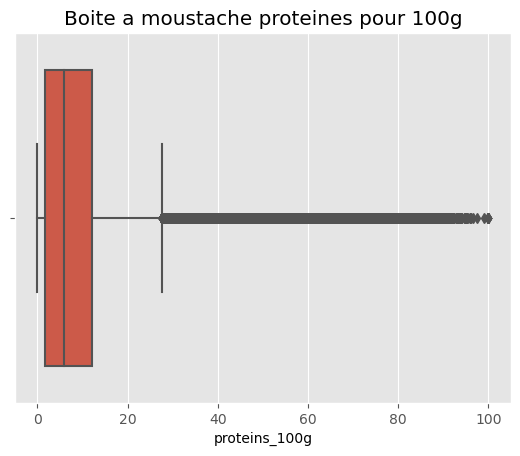

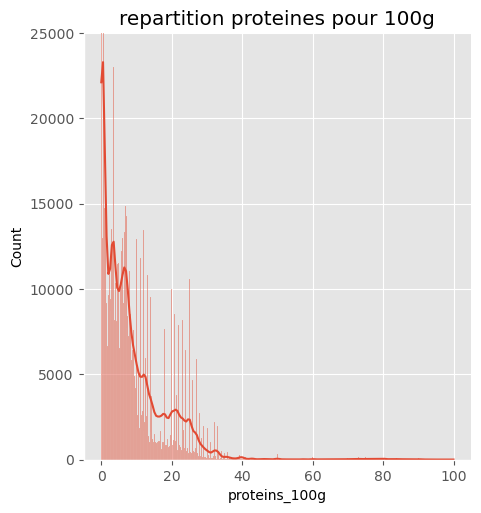

In [19]:
plot_univ(df,'proteins_100g','proteines',25000)

analyse univariée colonne sugars_100g
moyenne : 12.259214222038784
ecart type : 18.328981522171865
min : 0.0
50% : 3.51
75% : 15.82
max : 100.0


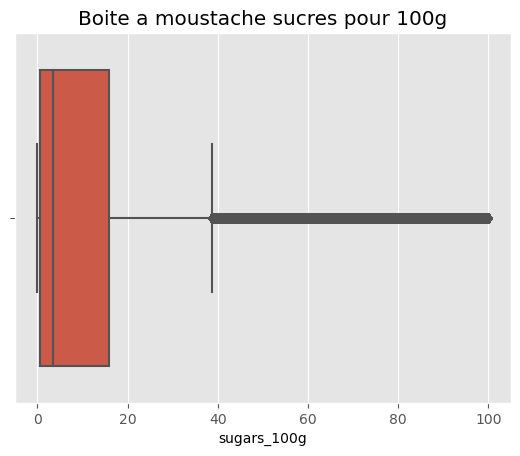

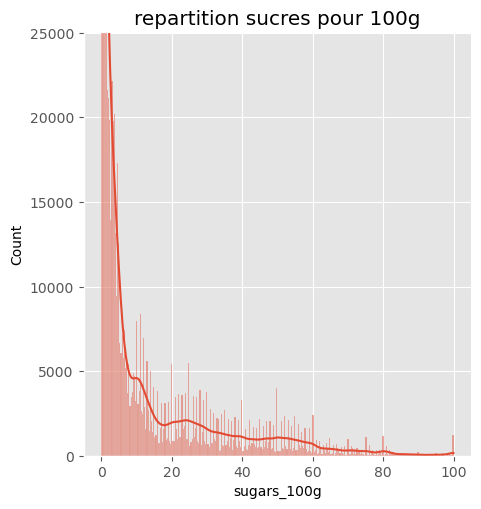

In [20]:
plot_univ(df,'sugars_100g','sucres',25000)

analyse univariée colonne saturated-fat_100g
moyenne : 5.03115628047383
ecart type : 7.705201390262336
min : 0.0
50% : 1.8
75% : 7.02
max : 100.0


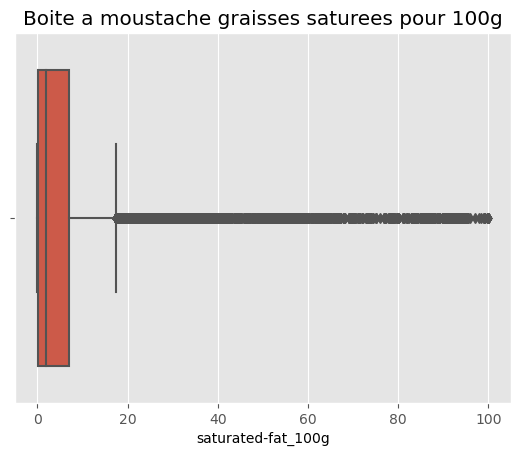

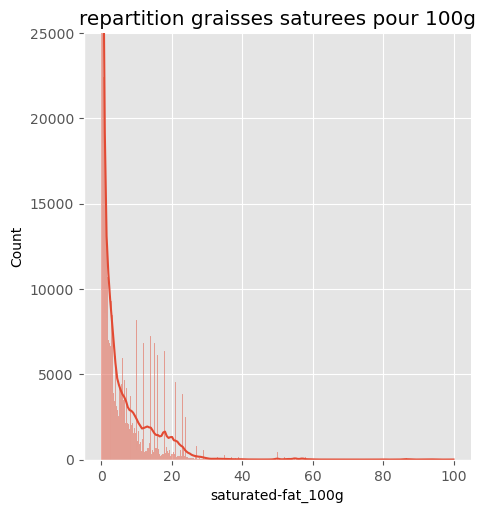

In [21]:
plot_univ(df,'saturated-fat_100g','graisses saturees',25000)

In [22]:
plot_univ(df,'fiber_100g','fibres',5000)

analyse univariée colonne fiber_100g
moyenne : 1.8884361749764937
ecart type : 2.7684710912494723
min : 0.0
50% : 1.0
75% : 2.6
max : 91.38


analyse univariée colonne fat_100g
moyenne : 13.403413418519937
ecart type : 17.179160690757552
min : 0.0
50% : 7.0
75% : 21.0
max : 100.0


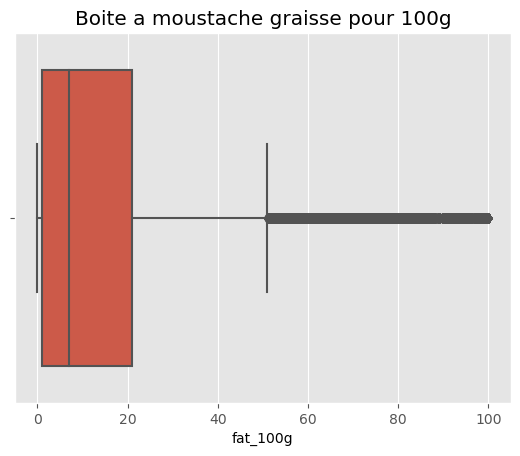

In [23]:
plot_univ(df,'fat_100g','graisse',25000)

In [24]:
df_grade = df['nutriscore_score'].value_counts().sort_index()
sns.barplot(x=df_grade.index, y= df_grade.values, color='royalblue')
plt.title('grade NUTRISCORE en France')
plt.savefig('nutriscore_grade_fr.jpg', bbox_inches='tight')
plt.show()

In [25]:
df['nutriscore_score'].describe()

count    856219.000000
mean          8.990573
std           8.600649
min         -15.000000
25%           1.000000
50%          10.000000
75%          15.000000
max          40.000000
Name: nutriscore_score, dtype: float64

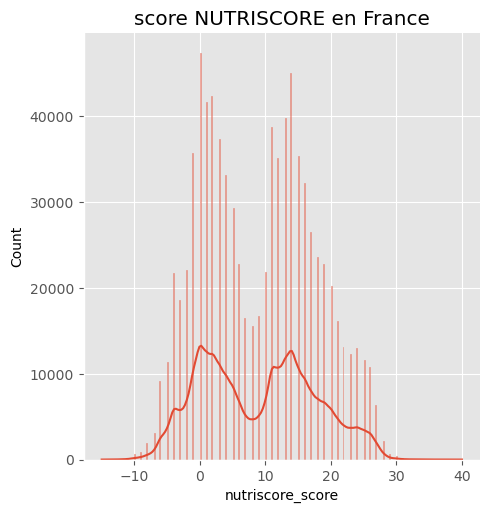

In [26]:
sns.displot(df['nutriscore_score'], kde = True)
plt.title('score NUTRISCORE en France')
plt.savefig('nutriscore_score_fr.jpg', bbox_inches='tight')
plt.show()

In [27]:
sns.boxplot(x='nutriscore_score', data = df)
plt.title('Boite a moustache score NUTRISCORE en France')
plt.savefig('nutriscore_score_fr_boxplot.jpg', bbox_inches='tight')
plt.show()

- Coefficient de corrélation de Pearson

In [28]:
df.corr().reindex(['nutriscore_score'],axis=1)

nutriscore_score
nutriscore_score            1.000000
energy_100g                 0.568272
fat_100g                    0.492945
saturated-fat_100g          0.576799
carbohydrates_100g          0.222884
sugars_100g                 0.420313
fiber_100g                 -0.128098
proteins_100g               0.068004
salt_100g                   0.155861
sodium_100g                 0.154975

In [29]:
test_pearson = pd.DataFrame(columns=['coef_pearson','p_value'])
for i in range(1,len(df.columns)):
    temp=df[['nutriscore_score',df.columns[i]]].dropna()
    pear, pval = stats.pearsonr(temp['nutriscore_score'], temp[df.columns[i]])
    test_pearson.loc[df.columns[i]]=[pear,pval]
    
test_pearson  

coef_pearson  p_value
energy_100g             0.568272      0.0
fat_100g                0.492945      0.0
saturated-fat_100g      0.576799      0.0
carbohydrates_100g      0.222884      0.0
sugars_100g             0.420313      0.0
fiber_100g             -0.128098      0.0
proteins_100g           0.068004      0.0
salt_100g               0.155861      0.0
sodium_100g             0.154975      0.0

In [30]:
df.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['nutriscore_score', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')>

In [31]:
columns=df[['energy_100g',
      'fat_100g',
      'saturated-fat_100g',
      'carbohydrates_100g',
      'sugars_100g',
       'fiber_100g',
      'proteins_100g',
      'salt_100g',
      'sodium_100g',]].describe()

### 2 - Analyses Bivariées

#### Analyse bivariée Nutriscore 


Text(0.5, 0.98, 'Corrélation Nutriscore_score avec autres features')

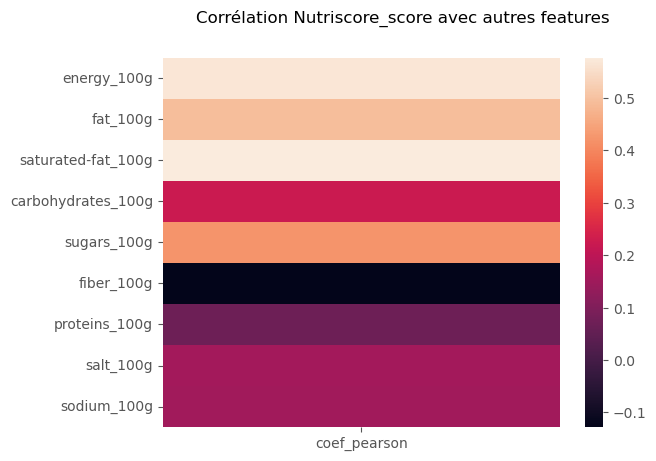

In [32]:
sns.heatmap(test_pearson.drop(columns=['p_value']))
plt.suptitle('Corrélation Nutriscore_score avec autres features')

Nous pouvons observer une corrélation significative entre les caractéristiques suivantes:

- énergie (energy)
- graisses et graisses saturées (fat & saturated-fat )
- sucres (sugars)

<Axes: >

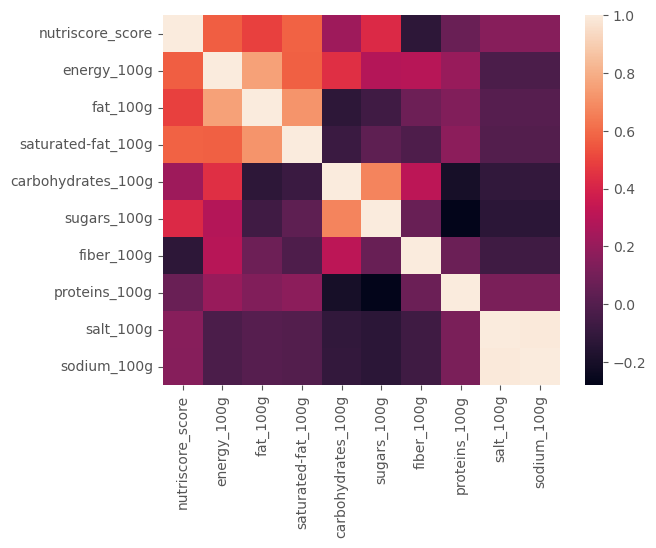

In [33]:
sns.heatmap(df.corr())

Nous pouvons observer une corrélation significative entre les caractéristiques suivantes:

- energy_100g / fat_100g
- graisses / graisses saturées (fat/ saturated-fat)
- glucides / sucres (carbohydrates/ sugars)
- sel / sodium (salt/sodium)

#### Test du Chi 2 - Indépendance des variables

In [34]:
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy.stats import chi2_contingency
from scipy.stats import chi2
def test_chi2(serie1, serie2):
    
    alpha = 0.03    
    
    #H0 : les variables sont indépendantes
    
    #print('tableau de contingence :\n', pd.crosstab(serie1.array, serie2.array))
    tab_contingence = pd.crosstab(serie1.array, serie2.array)
    stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
    print('chi2 : {0:.5f},\np : {0:.5f},\ndof : {0:.5f}\n'.format(stat_chi2, p, dof))
    
    
    #print('tableau de contingence : \n', tab_contingence)
    critical = chi2.ppf(1-alpha, dof) #
    #print('critital : ', critical)

    if p <= alpha:
        print('Variables non indépendantes (H0 rejetée) car p = {} <= alpha = {}'.format(p, alpha))
        return False
    
    else:
        print('H0 non rejetée car p = {} >= alpha = {}'.format(p, alpha))
        return True

### Test de normalité (Kolmogorov-Smirnov)

In [35]:
alpha= 0.05
print('===================\nnull hypothèse : la caractéristique étudiée suit une distribution normale.\n ===================\n\n')

for i in range(len(df.columns)): 
    temp=df[[df.columns[i]]].dropna()
    D, pval = stats.kstest(temp[df.columns[i]] , 'norm')
    print('D= {}\nP-value= {}'.format(D,pval))
    if pval<alpha: 
        print('P-value est inférieure à alpha ({}) nous pouvons rejeter l’hypothèse nulle\n => {} ne suit pas la distribution normale'
              .format(alpha,df.columns[i]))
    else : 
        print('Nous ne pouvons pas rejeter l’hypothèse nulle')
    print('----------------\n')
    

null hypothèse : la caractéristique étudiée suit une distribution normale.


D= 0.7268151077860476
P-value= 0.0
P-value est inférieure à alpha (0.05) nous pouvons rejeter l’hypothèse nulle
 => nutriscore_score ne suit pas la distribution normale
----------------

D= 0.9845295216305512
P-value= 0.0
P-value est inférieure à alpha (0.05) nous pouvons rejeter l’hypothèse nulle
 => energy_100g ne suit pas la distribution normale
----------------

D= 0.6547996537958887
P-value= 0.0
P-value est inférieure à alpha (0.05) nous pouvons rejeter l’hypothèse nulle
 => fat_100g ne suit pas la distribution normale
----------------

D= 0.5
P-value= 0.0
P-value est inférieure à alpha (0.05) nous pouvons rejeter l’hypothèse nulle
 => saturated-fat_100g ne suit pas la distribution normale
----------------

D= 0.7754381820228959
P-value= 0.0
P-value est inférieure à alpha (0.05) nous pouvons rejeter l’hypothèse nulle
 => carbohydrates_100g ne suit pas la distribution normale
----------------

D= 0.5907988

Le test de Kolmogorov Smirnov confirme la non-normalité des distributions de données : il n'est pas possible de procéder à une analyse de variance.

### Test ANOVA (Analyse de la variance) - Indépendance des variables


A : test de normalité 

In [36]:
nutriscore_range = df['nutriscore_score'].max()-df['nutriscore_score'].min()
print('Gap in each bin :',nutriscore_range/5)

Gap in each bin : 11.0


In [37]:
starting_value = -15
# Gap rounded up 
gap = 11
bins=[]
for i in range(6):
    bins.append(starting_value+i*gap)
labels=['a','b','c','d','e']


df['binned'] = pd.cut(df['nutriscore_score'], bins=bins, labels=labels)
df.head()

nutriscore_score  energy_100g  fat_100g  saturated-fat_100g  \
0              -5.0        238.0       0.2                 0.1   
1              18.0        936.0       8.2                 2.2   
2               9.0        264.0       0.0                 0.0   
3               1.0        134.0       0.3                 0.1   
4              14.0       1594.0      22.0                15.5   

   carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                 3.9          3.9        0.02           10.0       0.09   
1                29.0         22.0        0.00            5.1       4.60   
2                15.5         15.5        0.70            0.2       0.00   
3                 5.3          3.9        1.10            0.9       0.42   
4                27.3         21.9        4.40            4.6       0.10   

   sodium_100g binned  
0        0.036      a  
1        1.840      c  
2        0.000      c  
3        0.168      b  
4        0.040      c

In [38]:
cols = df.columns[1:-1].tolist()
cols 

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

#### ANOVA : analyse de la variance

B : Analyse de la variance

In [39]:
from scipy import stats

F, p = stats.f_oneway(df.loc[df["binned"] == 'a',cols],
                      df.loc[df["binned"] == 'b',cols],
                      df.loc[df["binned"] == 'c',cols],
                      df.loc[df["binned"] == 'd',cols],
                      df.loc[df["binned"] == 'e',cols])

                      
F, p

(array([ 96535.35235009,  61053.81127554, 104679.97675045,  15375.82263312,
         42030.91547783,  10889.38947587,   2408.7986403 ,   6953.5458785 ,
          6891.66798621]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [40]:
df.head()

nutriscore_score  energy_100g  fat_100g  saturated-fat_100g  \
0              -5.0        238.0       0.2                 0.1   
1              18.0        936.0       8.2                 2.2   
2               9.0        264.0       0.0                 0.0   
3               1.0        134.0       0.3                 0.1   
4              14.0       1594.0      22.0                15.5   

   carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                 3.9          3.9        0.02           10.0       0.09   
1                29.0         22.0        0.00            5.1       4.60   
2                15.5         15.5        0.70            0.2       0.00   
3                 5.3          3.9        1.10            0.9       0.42   
4                27.3         21.9        4.40            4.6       0.10   

   sodium_100g binned  
0        0.036      a  
1        1.840      c  
2        0.000      c  
3        0.168      b  
4        0.040      c

In [41]:
resultat_anova =pd.DataFrame(columns=['F','P_value'])
for i in range(len(cols)):
    resultat_anova.loc[cols[i]]=[F[i],p[i]]
resultat_anova

F  P_value
energy_100g          96535.352350      0.0
fat_100g             61053.811276      0.0
saturated-fat_100g  104679.976750      0.0
carbohydrates_100g   15375.822633      0.0
sugars_100g          42030.915478      0.0
fiber_100g           10889.389476      0.0
proteins_100g         2408.798640      0.0
salt_100g             6953.545879      0.0
sodium_100g           6891.667986      0.0

<Axes: xlabel='energy_100g', ylabel='binned'>

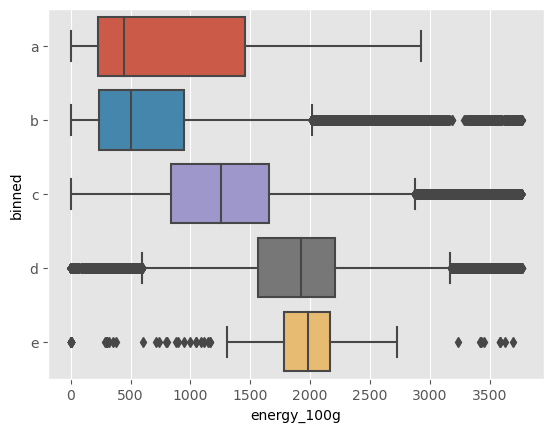

In [42]:
sns.boxplot(x='energy_100g', y='binned',data=df)

- Objectif : Le test ANOVA permet d'examiner le comportement d'une variable quantitative sur une ou plusieurs variables qualitatives.
- P Value = 0 ( l'hypothèse HO peut être rejetée avec 0% de risque, donc les catégories influencent la distribution des variables étudiées).
               
               
- Le résultat du test a été relativisé, nous ne remplissons pas la condition normale de nos données ( nécessaire pour le test ANOVA).



## Analyse multivariée

### Analyse en composantes principales (ACP) / PCA

Nous réalisons l'analyse multivariée grâce à une ACP sur les variables quantitatives. Voici les variables utilisées:
- energy_100g
- fat_100g
- saturated-fat_100g
- carbohydrates_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g

In [43]:
df_pca = df.copy()
df_pca.drop(columns=['nutriscore_score','binned'],inplace=True)
print(df_pca)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
standard = df_pca.values
standard
scaler= StandardScaler()
x_scaler = scaler.fit_transform(standard)
print(x_scaler)

[[-1.12525435 -0.76857196 -0.63997797 ...  0.16109283 -0.35630318
  -0.35449714]
 [-0.2028319  -0.30289119 -0.36743464 ... -0.36426643  1.29715561
   1.2893103 ]
 [-1.09089478 -0.78021397 -0.65295623 ... -0.8896257  -0.38929904
  -0.38730039]
 ...
 [ 1.94860614  2.41195255  0.18435046 ...  1.16408287 -0.3153836
  -0.3138164 ]
 [ 1.15040677  0.50040813 -0.32849988 ... -0.26777188  0.5272524
   0.52390107]
 [-0.32309041  0.26756774 -0.47126067 ... -0.75024467  0.17896286
   0.17764452]]


In [45]:
from sklearn.decomposition import PCA
pca = PCA()
df_pca = pca.fit_transform(x_scaler)

Variance Ratio(%) :  [28.1 25.1 19.  12.   8.3  4.1  2.9  0.5  0.1]


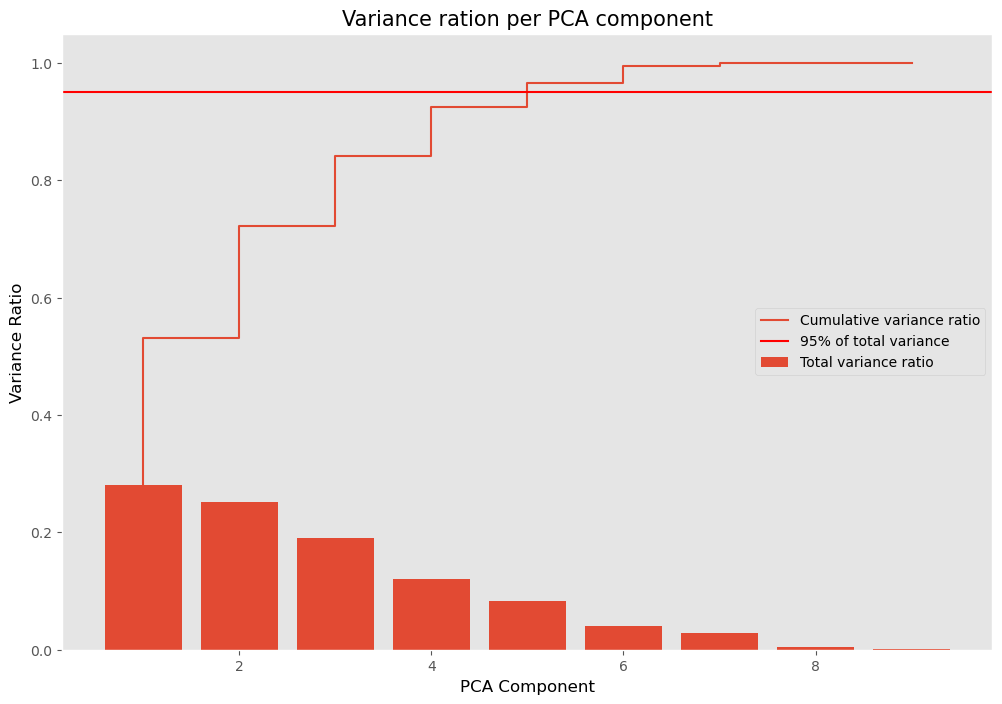

In [46]:
var_ratio = pca.explained_variance_ratio_
print('Variance Ratio(%) : ',np.around(var_ratio*100,1))
plt.figure(figsize=(12,8))
plt.bar(range(1,len(var_ratio)+1),var_ratio,align='center',label='Total variance ratio')
plt.step(range(1,len(var_ratio)+1),np.cumsum(var_ratio),label='Cumulative variance ratio')
plt.axhline(y=0.95,color='red',label='95% of total variance')
plt.xlabel('PCA Component',fontsize=12)
plt.ylabel('Variance Ratio',fontsize=12)
plt.legend(loc=7)
plt.title('Variance ration per PCA component',fontsize=15)
plt.grid()
plt.show()

                                    Avec 8/9 variables nous gardons 95% du signal 

Eigen Values :  [2.5251159  2.26267349 1.70656051 1.08321208 0.74575344 0.36789064
 0.261983   0.04152849 0.00529296] 
-------------



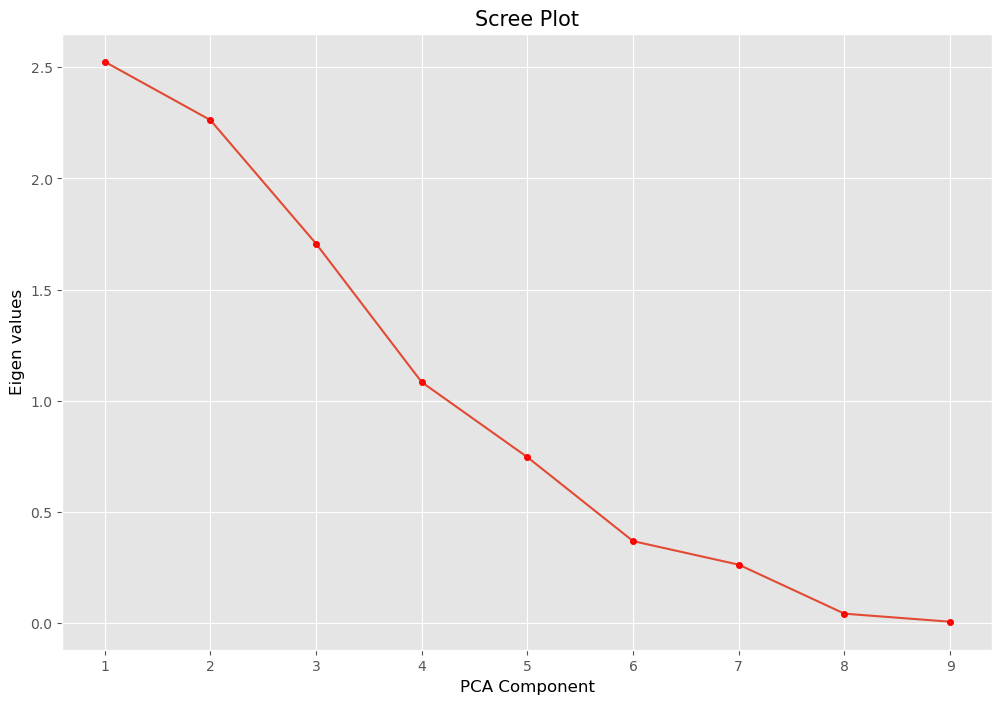

In [47]:
aeigen_values = pca.explained_variance_
print('Eigen Values : ',eigen_values,'\n-------------\n')

plt.figure(figsize=(12,8))
plt.plot(range(1,len(eigen_values)+1),eigen_values,marker='.',mec='r',mew=2)
plt.title('Scree Plot',fontsize=15)
plt.ylabel("Eigen values",fontsize=12)
plt.xlabel("PCA Component",fontsize=12)
plt.show()

[-0.58710993 -0.48505329 -0.44612732 -0.26373135 -0.23710161 -0.21468385
 -0.08164195  0.14570159  0.14574201] 
 [ 0.09356959  0.29724525  0.26845743 -0.3636963  -0.35357271 -0.10643386
  0.30486748  0.4845631   0.48420883]


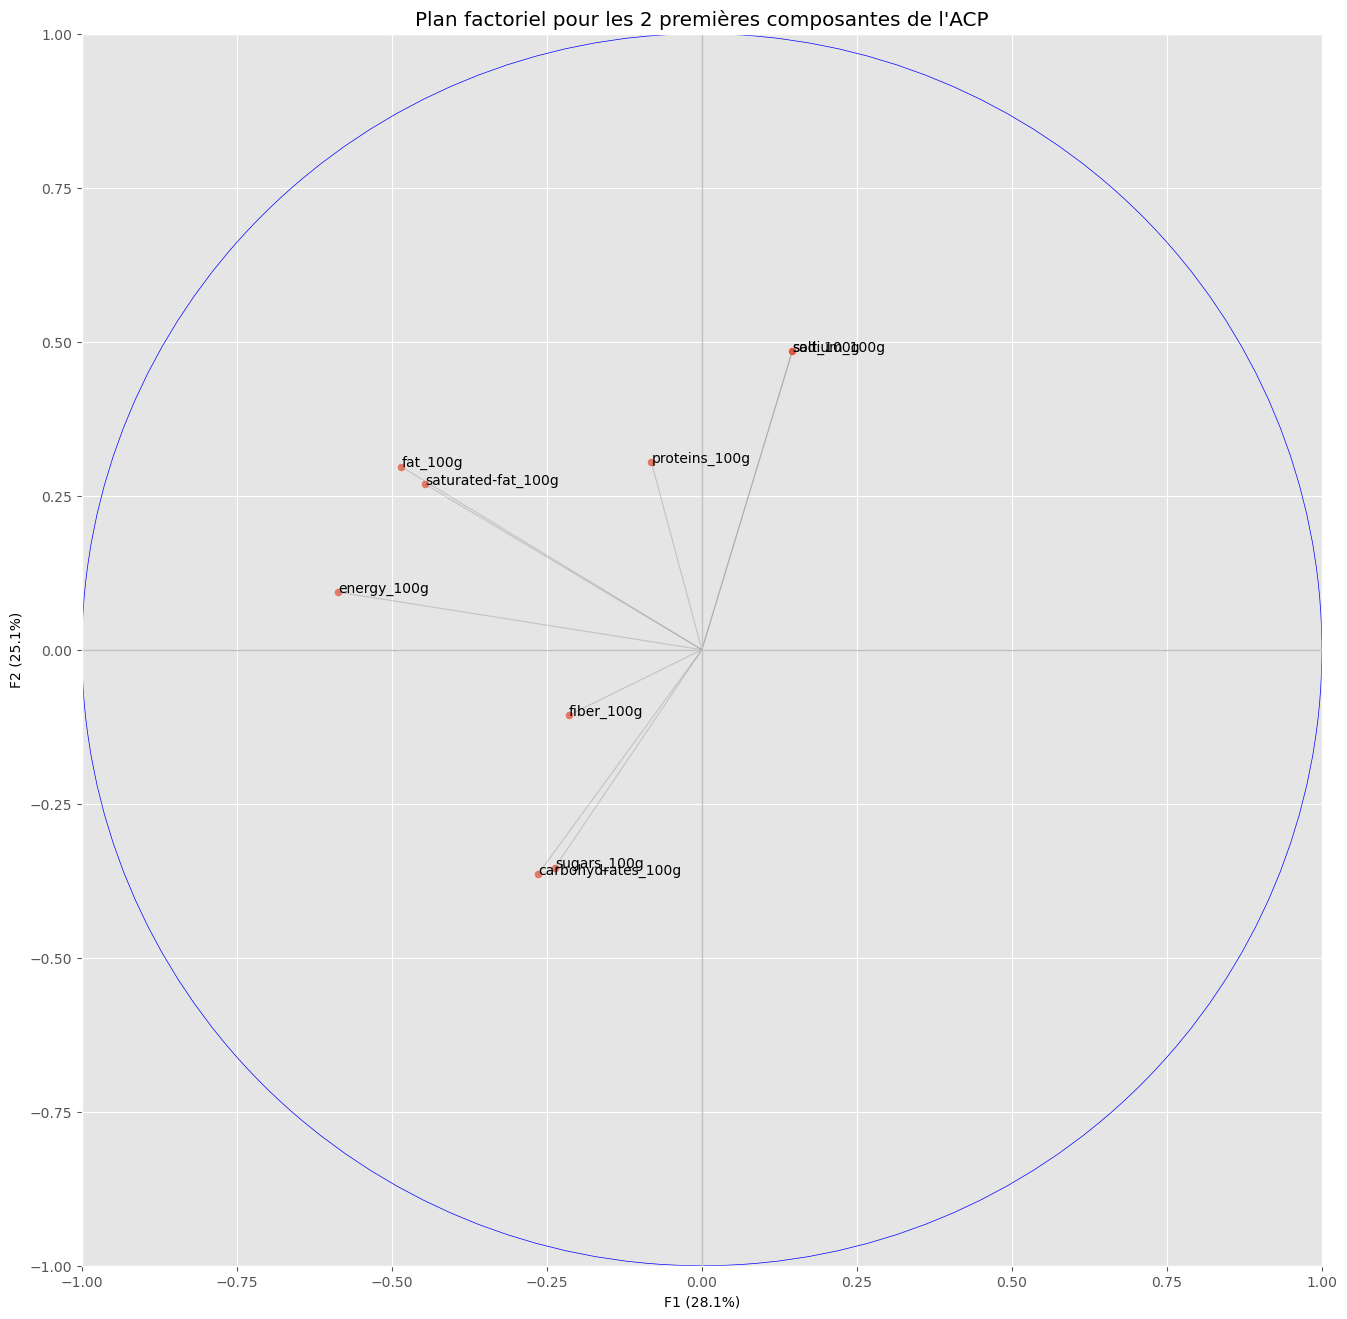

In [48]:
xpca =pca.components_[0,:]
ypca =pca.components_[1,:]

print(pca.components_[0,:],'\n',pca.components_[1,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les 2 premières composantes de l'ACP")
plt.xlabel('F1 ({}%)'.format(np.around(var_ratio[0]*100,1)))
plt.ylabel('F2 ({}%)'.format(np.around(var_ratio[1]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

- Energy_100g est très lié à l'axe des abscisses
- Protéines 100g est très lié à  l’axe des ordonnées



Nous constatons la même chose que dans notre matrice, 
nous pouvons en tenir compte pour la partie prédiction.


[ 0.11145408 -0.18148235 -0.17532414  0.47664125  0.40338109  0.16576971
 -0.1644529   0.48943256  0.48982836] 
 [ 0.05593839 -0.1659204  -0.26681819  0.08169448 -0.27784811  0.72117476
  0.53916547 -0.04155805 -0.04190834]


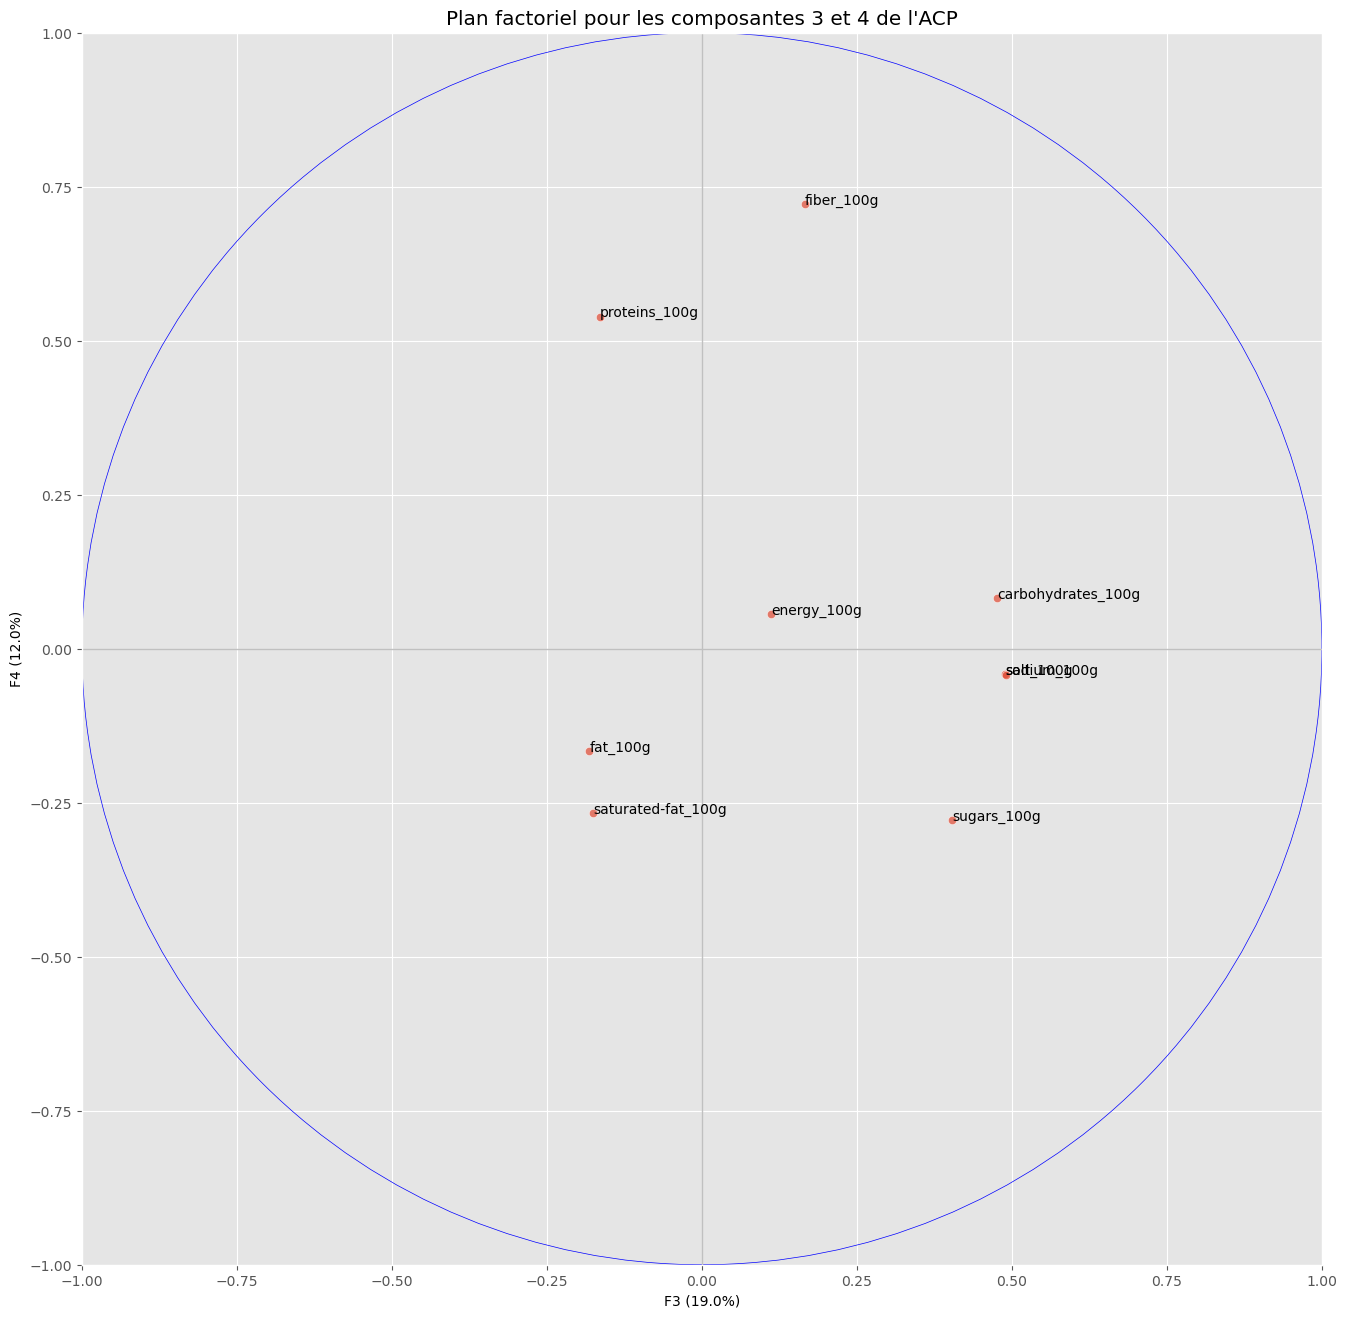

In [49]:
xpca =pca.components_[2,:]
ypca =pca.components_[3,:]

print(pca.components_[2,:],'\n',pca.components_[3,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les composantes 3 et 4 de l'ACP")
plt.xlabel('F3 ({}%)'.format(np.around(var_ratio[2]*100,1)))
plt.ylabel('F4 ({}%)'.format(np.around(var_ratio[3]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0)

Que ce soit pour les composantes 1, 2, 3 ou 4 (en tout 85% de l'inertie totale des composantes), on observe des corrélations fortes entre certaines features :

- Sodium & salt (+++)
- Fat & Saturated Fat (++)
- Carbohydrates & sugars (+)

In [50]:
cols

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

### Régression linéaire


- Préparation jeu de données

In [51]:
df_reg = df[df['nutriscore_score'].isna() == False].select_dtypes(['int32','float64']).dropna()

In [52]:
df[df['nutriscore_score'].isna() == False].select_dtypes(['int32','float64']).shape

(856219, 10)

In [53]:
df[df['nutriscore_score'].isna() == False].select_dtypes(['int32','float64']).dropna(axis=0).shape

(856219, 10)

In [54]:
df[df['nutriscore_score'].isna() == False].select_dtypes(['int32','float64']).isna().sum().sort_values(ascending=False)

nutriscore_score      0
energy_100g           0
fat_100g              0
saturated-fat_100g    0
carbohydrates_100g    0
sugars_100g           0
fiber_100g            0
proteins_100g         0
salt_100g             0
sodium_100g           0
dtype: int64

Effectuons notre analyse sur un ensemble de données sans les variables fibres_s_100g et nutriscore_score, afin de maximiser la taille de notre échantillon (100 000 observations conservées au lieu de 460)

In [55]:
df_reg = df[df['nutriscore_score'].isna() == False].select_dtypes(['int32','float64'])

In [56]:
df_reg = df_reg.drop(['fiber_100g'], axis=1).dropna(axis=0)

In [57]:
df_reg.shape

(856219, 9)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df_reg.copy()
y = X['nutriscore_score']
X = X.drop(['nutriscore_score'],axis=1)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

### Régression linéaire multiple

In [59]:
lr = LinearRegression().fit(X_train, y_train)
print('R² sur jeu d\'entraînement : ', lr.score(X_train,y_train))
print('R² sur jeu de test', lr.score(X_test,y_test))
print('Poids de chaque variable dans la régression', lr.coef_)
print('ordonnée à l\'origine', lr.intercept_)

R² sur jeu d'entraînement :  0.5757082519790258
R² sur jeu de test 0.5760227197434253
Poids de chaque variable dans la régression [ 2.13235873  0.380878    3.21448353 -1.13234797  3.96633979  0.2198381
  1.64173551  0.1012079 ]
ordonnée à l'origine 8.996232729555102


Nous avons un coefficient R² de 0,57 pour le jeu de test, ce qui est un assez mauvais résultat.

La régression ne tient pas compte du jeu de données.

In [60]:
resultat = pd.DataFrame({'nutriscore_reel' : y_test, 'prediction' : lr.predict(X_test)}).reset_index()

In [61]:
resultat.head()

index  nutriscore_reel  prediction
0  560165             22.0   17.344652
1  644659             24.0   14.173436
2  542947             10.0   11.813404
3  384362             14.0    3.370251
4  270118              0.0    1.481456

In [62]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.title('Comparaison des nutriscores estimés linéairement et réels')
sns.scatterplot(x = resultat['nutriscore_reel'], y = resultat['prediction'], alpha=0.8)
ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print('root mean squared error : ', sqrt(mean_squared_error(y_true = resultat['nutriscore_reel'], y_pred = resultat['prediction'])))

root mean squared error :  5.604217592332288


In [64]:
compare = abs(resultat['nutriscore_reel'] - resultat['prediction'])

In [65]:
compare.sum()/len(compare)

4.412779533900371

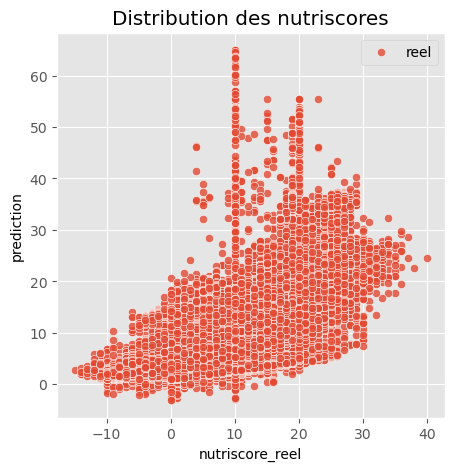

In [66]:
plt.figure(figsize=(5,5))
plt.title('Distribution des nutriscores')
sns.scatterplot( x = resultat['nutriscore_reel'], y = resultat['prediction'], alpha=0.8)
plt.legend(['reel', 'prediction'])
plt.show()

In [67]:
plt.figure(figsize=(5,5))
plt.title('Distribution des nutriscores')
sns.distplot(resultat['nutriscore_reel'], bins=20, rug=True)
sns.distplot(resultat['prediction'], bins = 20, rug=True)
plt.legend(['reel', 'prediction'])
plt.show()

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_4598/3662732356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resultat['nutriscore_reel'], bins=20, rug=True)
/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_4598/3662732356.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

In [68]:
pertinence_variables = pd.DataFrame()

In [69]:
pertinence_variables['coefs'] = lr.coef_.T

In [70]:
pertinence_variables

coefs
0  2.132359
1  0.380878
2  3.214484
3 -1.132348
4  3.966340
5  0.219838
6  1.641736
7  0.101208

In [71]:
pertinence_variables['colonnes']= df_reg.drop(['nutriscore_score'], axis=1).columns.tolist()

In [72]:
pertinence_variables['coefs'] = abs(pertinence_variables['coefs'])

In [73]:
pertinence_variables.sort_values(by='coefs', inplace=True, ascending=False)

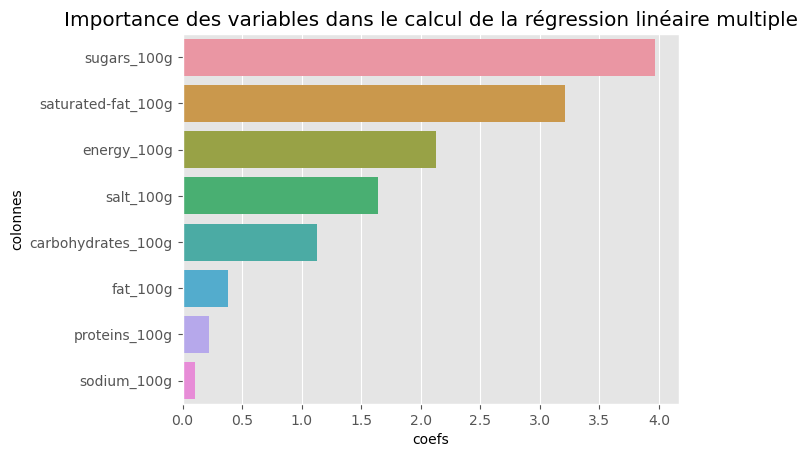

In [74]:
plt.title('Importance des variables dans le calcul de la régression linéaire multiple')
sns.barplot(x = pertinence_variables['coefs'], y =pertinence_variables['colonnes'])
plt.show()

Après le nettoyage et l'analyse des données, certaines variables sont requises pour prédire le Nutri-Score automatique:

- L’Energy 
- Le Sucre 
- La Graisse 
- La Graisse Saturée 

